In [1]:
# AF: With the baseline evolution code commented out, this may not be necessary
#!pip install numba
#!pip install mpmath

In [2]:
import os,sys,time
import numpy as np
import pandas
import scipy.special
import torch

# matplotlib, just for testing
import matplotlib as mpl
mpl.rc('font',size=20,family='Libertine',weight='normal')
mpl.rc('text',usetex=True)
mpl.rc('text.latex', preamble=r"\usepackage{bm}")
from matplotlib import pyplot as plt

# QCD things
from alphaS import get_alphaS, get_Nf

In [3]:
print(torch.cuda.is_available())
torch.cuda.empty_cache()

True


In [4]:
#--fipack modules
#--Attention: you need to specify the location of fitpack.
#path='/w/jam-sciwork18/nsato/projects/jam/fitpack_legacy'
#sys.path.insert(0,path)
#os.environ['FITPACK']=path

#from tools.tools    import checkdir,load,isnumeric
#from tools.config   import conf,load_config,options
#from qcdlib import aux
#from qcdlib import mellin
#from qcdlib import alphaS
#from fitlib.resman import RESMAN

In [5]:
#replicas=np.load('/work/JAM/share/fitpack_grids/results/ccocuzza22/replicas.npy',allow_pickle=True).item(0)
#conf.update(replicas['conf'])
#resman=RESMAN(nworkers=1,parallel=False,datasets=False)
#resman.parman.order=replicas['order']
#resman.parman.set_new_params(replicas['params'][0],initial=True)

In [6]:
# Cell with a pixelated DoubleDistribution class
# TODO:
# - Routine to convert to pixelated GPD (in x,xi space)

class DoubleDistribution():
    ''' A class for creating double distribution objects.
    Currently this is at a single, fixed t value.
    Since the domain of the function is a diamond in (alpha,beta) space,
    I define auxilliary variables:
        gamma = alpha + beta
        delta = alpha - beta
    which both have [-1,+1] as their domain.
    The double distirbution grid is defined over a meshgrid of gamma and delta.
    However, alpha and beta values are also accessible.
    '''
    _default_pixel_length = 20
    _default_mu2 = 5
    _eps = 1e-6 # to avoid edge singularities
    
    def __init__(self, **kwargs):
        # Process kwargs
        b = kwargs.get('b', 1)
        pdf_routine = kwargs['pdf_routine']
        self.init_via_pdf(**kwargs)
        return
    
    def init_via_pdf(self, **kwargs):
        ''' Use Radyushkin's double distribution model with an input PDF function and parameter b.
        The pdf_routine function should take x, mu2, and a flavor string as arguments.
        '''
        assert('pdf_routine' in kwargs)
        pdf_routine = kwargs['pdf_routine']
        b = kwargs.get('b', 1)
        self.pixel_length = kwargs.get('pixel_length', self._default_pixel_length)
        self.mu2 = kwargs.get('mu2', self._default_mu2)
        #N = self.pixel_length # for shorter code
        gamma_array = torch.linspace(-1, 1, self.pixel_length).cuda()
        #gamma_array = torch.linspace(-1+self._eps, 1-self._eps, self.pixel_length).cuda()
        delta_array = torch.clone(gamma_array)
        self.gamma, self.delta = torch.meshgrid(gamma_array, delta_array, indexing='ij')
        self.alpha = (self.gamma + self.delta)/2
        # The range of beta is shrunk slightly to avoid singularities in the profile function
        self.beta  = (self.gamma - self.delta)/2 * (1-self._eps)
        profile = self.profile_function(self.alpha, self.beta, b)
        x = self.beta.cpu().numpy()
        self.u = profile * torch.tensor(pdf_routine(x, self.mu2, 'u')).cuda()
        self.d = profile * torch.tensor(pdf_routine(x, self.mu2, 'd')).cuda()
        self.s = profile * torch.tensor(pdf_routine(x, self.mu2, 's')).cuda()
        self.c = profile * torch.tensor(pdf_routine(x, self.mu2, 'c')).cuda()
        self.b = profile * torch.tensor(pdf_routine(x, self.mu2, 'b')).cuda()
        self.t = profile * torch.tensor(pdf_routine(x, self.mu2, 't')).cuda()
        self.g = profile * torch.tensor(pdf_routine(x, self.mu2, 'g')).cuda()
        return
    
    def profile_function(self, alpha, beta, b):
        # TODO: Gamma function
        Gamma = scipy.special.gamma
        x1 = Gamma(2*b+2)
        x2 = 2**(2*b+1)*(Gamma(b+1))**2
        x3 = ((1-abs(beta))**2-alpha**2)**b
        x4 = (1+self._eps-abs(beta))**(2*b+1)
        return x1*x3/(x2*x4)

In [7]:
class MODEL():
    _default_pixel_length = 20
    _default_mu2 = 5
    _eps = 1e-6 # to avoid edge singularities

    def __init__(self, **kwargs):
        self.pixel_length = kwargs.get('pixel_length', self._default_pixel_length)
        self.mu2 = kwargs.get('mu2', self._default_mu2)
        self.Nf = 4#get_Nf(mu2) # TODO
        self.DD = DoubleDistribution(**kwargs)
        self.initialize_GPDs()
        # Also need these for evolution...
        return

    def initialize_GPDs(self):
        ''' Creates images of the GPDs in x, xi space,
        by integrating down one dimension of the DDs analytically
        and one dimension numerically.
        '''
        # Make 2D arrays
        x_array = torch.linspace(-1+self._eps, 1-self._eps, self.pixel_length).cuda()
        xi_array = torch.linspace(self._eps, 1-self._eps, self.pixel_length//2).cuda()
        x, xi = torch.meshgrid(x_array, xi_array, indexing='ij')
        # Get needed 1D arrays
        gamma_array = self.DD.gamma.unique()
        delta_array = self.DD.delta.unique()
        # Make 3D arrays to integrate down...
        x3D, xi3D, delta3D = torch.meshgrid(x_array, xi_array, delta_array)
        # Original tensor is 1D thing of gammas;
        # The 3D array is values I need to set gamma to, by snapping to the grid.
        gamma3D_target = ((1-xi3D)*delta3D + 2*x3D) / (1+xi3D)
        # Get snapped indices for gamma
        gamma_indices = (gamma_array.repeat(*gamma3D_target.shape,1) - gamma3D_target.unsqueeze(-1)).abs().argmin(dim=-1).long()
        gamma3D = gamma_array[gamma_indices]
        blah = torch.linspace(0,self.pixel_length-1,self.pixel_length).int().cuda()
        # Snapped indices for delta
        delta_indices = blah.repeat(self.pixel_length, self.pixel_length//2, 1).long()
        # Masks to ensure integration range is obeyed
        mask1 = gamma3D_target > -1
        mask2 = gamma3D_target < 1
        # Integrands for all parton flavors
        intd_u = mask1 * mask2 * self.DD.u[gamma_indices,delta_indices]
        intd_d = mask1 * mask2 * self.DD.d[gamma_indices,delta_indices]
        intd_s = mask1 * mask2 * self.DD.s[gamma_indices,delta_indices]
        intd_c = mask1 * mask2 * self.DD.c[gamma_indices,delta_indices]
        intd_b = mask1 * mask2 * self.DD.b[gamma_indices,delta_indices]
        intd_t = mask1 * mask2 * self.DD.t[gamma_indices,delta_indices]
        intd_g = mask1 * mask2 * self.DD.g[gamma_indices,delta_indices]
        # Make all the GPDs
        Hu = torch.trapz(intd_u, delta3D, dim=2) / (1 + xi)
        Hd = torch.trapz(intd_d, delta3D, dim=2) / (1 + xi)
        Hs = torch.trapz(intd_s, delta3D, dim=2) / (1 + xi)
        Hc = torch.trapz(intd_c, delta3D, dim=2) / (1 + xi)
        Hb = torch.trapz(intd_b, delta3D, dim=2) / (1 + xi)
        Ht = torch.trapz(intd_t, delta3D, dim=2) / (1 + xi)
        Hg = torch.trapz(intd_g, delta3D, dim=2) / (1 + xi)
        # Save the produced grids
        self.x_ = x
        self.xi_ = xi
        self.Hu = Hu
        self.Hd = Hd
        self.Hs = Hs
        self.Hc = Hc
        self.Hb = Hb
        self.Ht = Ht
        self.Hg = Hg
        # Also need these to interface with Nobuo's evolution implementation...
        self.x   = x_array
        self.xi  = xi_array
        self.y   = torch.clone(x_array)
        self.nx  = self.x.shape[0]
        self.ny  = self.y.shape[0]
        self.nxi = self.xi.shape[0]
        return
    
    def get_NonSinglet(self):
        ''' A temporary routine for Nobuo to use.
        Gives the type-2 non-singlet array, Hu+ - Hd+
        '''
        Hu = self.Hu - torch.flip(self.Hu,[0])
        Hd = self.Hd - torch.flip(self.Hd,[0])
        return Hu - Hd

In [8]:
# A simple PDF to use for constructing double distributions
def silly_pdf_routine(x, mu2, q):
    up_piece   = 1/6*x*(1-x)
    down_piece = 1/6*x*(1+x)
    if(q=='u'):
        f = np.ma.masked_where(x <= 0, up_piece).filled(fill_value=0)
    elif(q=='d'):
        f = np.ma.masked_where(x >= 0, down_piece).filled(fill_value=0)
    else:
        f = np.zeros(len(x))
    return f

In [9]:
# A GPD model instance to test things with
Telemachus = MODEL(pdf_routine=silly_pdf_routine, pixel_length=76, b=1)

/opt/conda/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


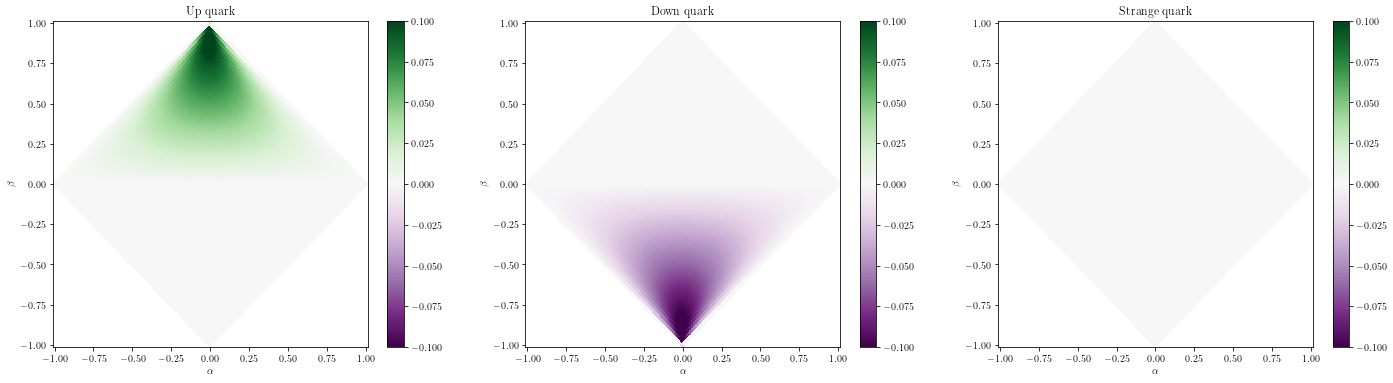

In [10]:
# Plots to look at the double distributions in the instance

# Variables to plot
alpha = Telemachus.DD.alpha.cpu().numpy()
beta  = Telemachus.DD.beta.cpu().numpy()
u     = Telemachus.DD.u.cpu().numpy()
d     = Telemachus.DD.d.cpu().numpy()
s     = Telemachus.DD.s.cpu().numpy()

# Overall plot with subplots
nrows,ncols=1,3
fig = plt.figure(figsize=(ncols*8,nrows*6))

# Up
ax1 = plt.subplot(nrows,ncols,1)
c = ax1.pcolor(alpha, beta, u, vmin=-0.1, vmax=0.1, cmap='PRGn')
_ = ax1.set_title(r'Up quark')
_ = ax1.set_xlabel(r'$\alpha$')  
_ = ax1.set_ylabel(r'$\beta$')    
fig.colorbar(c, ax=ax1)

# Down
ax2 = plt.subplot(nrows,ncols,2)
c = ax2.pcolor(alpha, beta, d, vmin=-0.1, vmax=0.1, cmap='PRGn')
_ = ax2.set_title(r'Down quark')
_ = ax2.set_xlabel(r'$\alpha$')  
_ = ax2.set_ylabel(r'$\beta$')    
fig.colorbar(c, ax=ax2)

# Strange
ax3 = plt.subplot(nrows,ncols,3)
c = ax3.pcolor(alpha, beta, s, vmin=-0.1, vmax=0.1, cmap='PRGn')
_ = ax3.set_title(r'Strange quark')
_ = ax3.set_xlabel(r'$\alpha$')  
_ = ax3.set_ylabel(r'$\beta$')    
fig.colorbar(c, ax=ax3)

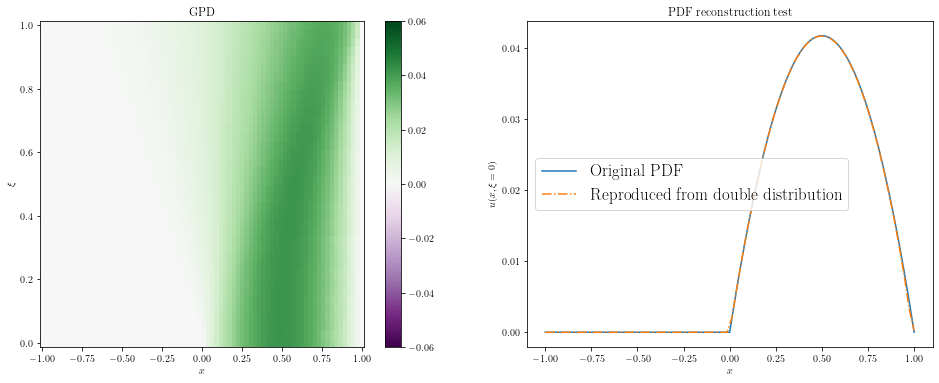

In [11]:
# Test cell for the GPD produced from the DD

# Arrays for pixel plots
x2D  = Telemachus.x_.cpu().numpy()
xi2D = Telemachus.xi_.cpu().numpy()
Hu2D = Telemachus.Hu.cpu().numpy()

# 1D arrays of original PDF
x1D = np.linspace(-1,1,151)
u1D = silly_pdf_routine(x1D, 5, 'u')

# Overall plot with subplots
nrows,ncols=1,2
fig = plt.figure(figsize=(ncols*8,nrows*6))

# 2D test plot
ax1 = plt.subplot(nrows,ncols,1)
c = ax1.pcolor(x2D, xi2D, Hu2D, vmin=-0.06, vmax=0.06, cmap='PRGn')
_ = ax1.set_title(r'GPD')
_ = ax1.set_xlabel(r'$x$')  
_ = ax1.set_ylabel(r'$\xi$')    
fig.colorbar(c, ax=ax1)

# Comparison plot
ax2 = plt.subplot(nrows,ncols,2)
_ = ax2.plot(x1D, u1D, label=r'Original PDF', linestyle='-')
_ = ax2.plot(x2D[:,0], Hu2D[:,0], label=r'Reproduced from double distribution', linestyle='-.')
_ = ax2.set_title(r'PDF reconstruction test')
_ = ax2.set_xlabel(r'$x$')
_ = ax2.set_ylabel(r'$u(x,\xi=0)$')
_ = ax2.legend(prop={'size': 17})

In [12]:
class BASE:
    
    def __init__(self, model):
        self.diff__ = torch.zeros(model.ny,model.nx,model.nxi).cuda()
        self.zeros_ = torch.zeros(model.nx,model.nxi).cuda()
        return

    def neg_dglap(self,x,xi):
        return x<-xi

    def pos_dglap(self,x,xi):
        return x>+xi

    def erbl(self,x,xi):
        return (x>-xi)*(x<+xi)

    def pos_erbl(self,x,xi):
        return (x>0)*(x<+xi)
    
    def get_conv(self,K,H,Hsub):
        for _ in range(self.model.nxi): self.diff__[:,:,_]=H[:,_].reshape(-1,1)-Hsub[:,_]
        return torch.trapz(K*self.diff__,self.y__,dim=0)
    
    def test(self,msg,tensor):
        print(msg,torch.any(torch.isinf(tensor)),torch.any(torch.isnan(tensor)))
        return


In [13]:
class NonSingletEvolution(BASE):

    def __init__(self,model):
        self.model = model
        super().__init__(model)
        self.setup_kernels(model)
        return
    
    def setup_kernels(self,model):
        
        #! y depedent kernels 
        y,x,xi = torch.meshgrid(model.y,model.x,model.xi)
        self.y__=y
        
        KL=(2*xi**2-x**2-y**2)/(y-x)/(y**2-xi**2) 
        KL[y>=x]=0
        KL[torch.logical_not(self.neg_dglap(x,xi))]=0
        KM1=(x+xi)*(y-x+2*xi)/xi/(y+xi)/(y-x) 
        KM1[y<=x]=0
        KM2=(x-xi)*(y-x-2*xi)/xi/(y-xi)/(y-x)
        KM2[y>=x]=0
        KM=KM1+KM2
        KM[torch.logical_not(self.erbl(x,xi))]=0
        KR=(-2*xi**2+x**2+y**2)/(y-x)/(y**2-xi**2)
        KR[y<=x]=0
        KR[torch.logical_not(self.pos_dglap(x,xi))]=0
        self.K0 = (2*KL + KM + 2*KR)/(3*np.pi)
        
        #! y indepedent kernels 
        x,xi = torch.meshgrid(model.x,model.xi)
        
        KL=3/2+2*torch.log(1+x) + (x-xi)/(2*xi) * torch.log((xi-x)*(1-xi)) - (x+xi)/(2*xi)*torch.log((-xi-x)*(1+xi))
        KL[torch.logical_not(self.neg_dglap(x,xi))]=0
        KM=3+2*torch.log((1-x**2)/(1+xi))+(x-xi)/xi*torch.log(xi-x)-(x+xi)/xi*torch.log(x+xi)
        KM[torch.logical_not(self.erbl(x,xi))]=0
        KR=3/2+2*torch.log(1-x)+(x-xi)/(2*xi)*torch.log((x-xi)*(1+xi))-(x+xi)/(2*xi)*torch.log((xi+x)*(1-xi))
        KR[torch.logical_not(self.pos_dglap(x,xi))]=0
        self.K1 = (2*KL + KM  + 2*KR)/(3*np.pi)
        
        return

    def get_shift(self,mu2,H):
        shift = self.get_conv(self.K0,H,H)
        shift+= self.K1*H
        aS=get_alphaS(mu2)
        #print(shift)
        return aS * shift    
        
    def evolve(self,H,mu2ini,mu2fin,steps=5,z2=0):
        dt = np.log(mu2fin/mu2ini)/steps
        t=0
        for k in range(steps):
            mu2= np.exp(t)*mu2ini
            H1 = self.get_shift(mu2,H)
            mu2= np.exp(t+dt/2)*mu2ini
            H2 = self.get_shift(mu2,H+dt*H1/2)
            H3 = self.get_shift(mu2,H+dt*H2/2)
            mu2= np.exp(t+dt)*mu2ini
            H4 = self.get_shift(mu2,H+dt*H3)
            H+=dt/6*(H1+2*H2+2*H3+H4)
            t+=dt
            mu2=np.exp(t)*mu2ini
        
        if z2!=0:
            H[self.model.x_<0]=0
            H+=z2*torch.flip(H, dims=[0])
        return H


In [14]:
# Test non-singlet evolution starting with the DD model
nsevo  = NonSingletEvolution(Telemachus)
mu2ini = Telemachus.mu2
H0     = torch.clone(Telemachus.Hu)
H10    = nsevo.evolve(torch.clone(H0),mu2ini,10,steps=5)
H100   = nsevo.evolve(torch.clone(H0),mu2ini,100,steps=5)

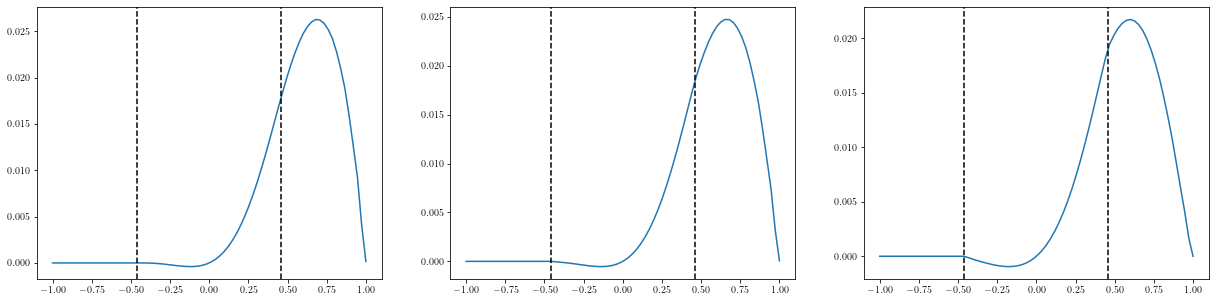

In [15]:
# Plots of evolved stuff

nrows,ncols=1,3
fig = plt.figure(figsize=(ncols*7,nrows*5))
ixi=17

ax=plt.subplot(nrows,ncols,1);ax1=ax
ax.plot(Telemachus.x.cpu().numpy(),(Telemachus.x_*H0).cpu().numpy()[:,ixi])
#ax.plot(xx,xx*G0,'k:')

ax=plt.subplot(nrows,ncols,2);ax2=ax
ax.plot(Telemachus.x.cpu().numpy(),(Telemachus.x_*H10).cpu().numpy()[:,ixi])
#ax.plot(xx,xx*G10,'k:')

ax=plt.subplot(nrows,ncols,3);ax3=ax
ax.plot(Telemachus.x.cpu().numpy(),(Telemachus.x_*H100).cpu().numpy()[:,ixi])
#ax.plot(xx,xx*G100,'k:')

for ax in [ax1,ax2,ax3]:
    ax.axvline( Telemachus.xi[ixi].cpu().numpy(),color='k',ls='--')
    ax.axvline(-Telemachus.xi[ixi].cpu().numpy(),color='k',ls='--')

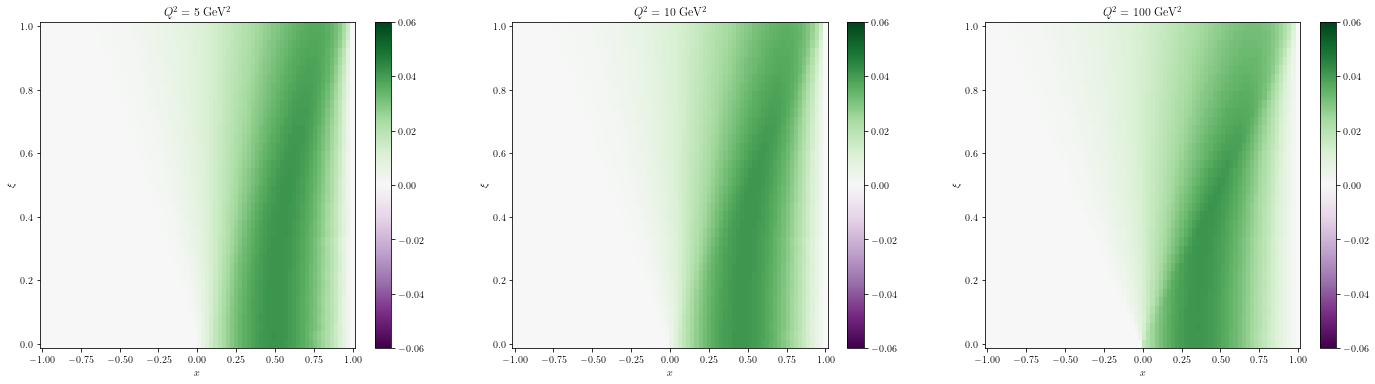

In [17]:
# Test cell for evolved GPD plots

# Overall plot with subplots
nrows,ncols=1,3
fig = plt.figure(figsize=(ncols*8,nrows*6))

# Reused arrays
x  = Telemachus.x_.cpu().numpy()
xi = Telemachus.xi_.cpu().numpy()

# Pre-evolution
ax1 = plt.subplot(nrows,ncols,1)
c = ax1.pcolor(x, xi, H0.cpu().numpy(), vmin=-0.06, vmax=0.06, cmap='PRGn')
_ = ax1.set_title(r'$Q^2=5$~GeV$^2$')
_ = ax1.set_xlabel(r'$x$')  
_ = ax1.set_ylabel(r'$\xi$')
fig.colorbar(c, ax=ax1)

# Some evolution
ax2 = plt.subplot(nrows,ncols,2)
c = ax2.pcolor(x, xi, H10.cpu().numpy(), vmin=-0.06, vmax=0.06, cmap='PRGn')
_ = ax2.set_title(r'$Q^2=10$~GeV$^2$')
_ = ax2.set_xlabel(r'$x$')  
_ = ax2.set_ylabel(r'$\xi$')
fig.colorbar(c, ax=ax2)

# Lotsa evolution
ax3 = plt.subplot(nrows,ncols,3)
c = ax3.pcolor(x, xi, H100.cpu().numpy(), vmin=-0.06, vmax=0.06, cmap='PRGn')
_ = ax3.set_title(r'$Q^2=100$~GeV$^2$')
_ = ax3.set_xlabel(r'$x$')  
_ = ax3.set_ylabel(r'$\xi$')
fig.colorbar(c, ax=ax3)

In [18]:
class SingletEvolutionQQ(BASE):

    def __init__(self,model):
        super().__init__(model)
        self.setup_kernels(model)
        self.model=model
    
    def test(self,msg,tensor):
        print(msg,torch.any(torch.isinf(tensor)),torch.any(torch.isnan(tensor)))

    def setup_kernels(self,model):
        
        #! y depedent kernels 
        y,x,xi = torch.meshgrid(model.y,model.x,model.xi)
        self.y__=y
        
        #! kernels without subtraction
        KM1=2*x/xi/(xi+y) 
        KM1[y<=x]=0
        KM2=2*(xi-x)/xi/(xi**2-y**2)*y 
        KM2[y<=0]=0; KM2[y>=x]=0
        KM=KM1+KM2
        KM[torch.logical_not(self.pos_erbl(x,xi))]=0
        self.K0=KM/(3*np.pi)

        #! kernels with subtraction
        KM1=4*x/(y**2-x**2)
        KM1[y<=x]=0
        KM2=-4*(xi**2-x**2)/(xi**2-y**2)/(y**2-x**2)*y
        KM2[y<=0]=0; KM2[y>=x]=0
        KM=KM1+KM2
        KM[torch.logical_not(self.pos_erbl(x,xi))]=0
        KR=(-2*xi**2+x**2+y**2)/(y-x)/(y**2-xi**2)
        KR[y<=x]=0
        KR[torch.logical_not(self.pos_dglap(x,xi))]=0
        self.K1=(KM+2*KR)/(3*np.pi)

        #! y indepedent kernels 
        x,xi = torch.meshgrid(model.x,model.xi)
        
        KM=2*(torch.log((1-x)/(1+x))+2*torch.log(x/xi)+3/2)
        KM[torch.logical_not(self.pos_erbl(x,xi))]=0
        KR=3/2+2*torch.log(1-x)+(x-xi)/(2*xi)*torch.log((x-xi)*(1+xi))-(x+xi)/(2*xi)*torch.log((xi+x)*(1-xi))
        KR[torch.logical_not(self.pos_dglap(x,xi))]=0
        self.K2=(KM+2*KR)/(3*np.pi)
        
    def get_shift(self,mu2,H):
        shift = self.get_conv(self.K0,H,self.zeros_)
        shift+= self.get_conv(self.K1,H,H)
        shift+= self.K2*H
        aS=get_alphaS(mu2)    
        return aS * shift    
    


In [19]:
class SingletEvolutionQG(BASE):

    def __init__(self,model):
        super().__init__(model)
        self.setup_kernels(model)
        self.model=model
    
    def setup_kernels(self,model):
        
        #! y depedent kernels 
        y,x,xi = torch.meshgrid(model.y,model.x,model.xi)
        self.y__=y
        
        #! kernels without subtraction
        KM=xi*x/(xi+y)**2/xi**2
        KM[y<=x]=0
        KM[torch.logical_not(self.pos_erbl(x,xi))]=0
        self.K0=KM/(2*np.pi)

        #! kernels with subtraction
        KM=(xi**4+xi**3*x-2*xi**2*x**2-(xi**2-xi*x)*y**2)/(xi**2-y**2)**2/xi**2
        KM[y>=x]=0; KM[y<=0]=0
        KM[torch.logical_not(self.pos_erbl(x,xi))]=0
        KR=(y**2-2*x*y+2*x**2-xi**2)/(xi**2-y**2)**2
        KR[y<=x]=0
        KR[torch.logical_not(self.pos_dglap(x,xi))]=0
        self.K1=(KM+KR)/(2*np.pi)
        
        #! y indepedent kernels 
        x,xi = torch.meshgrid(model.x,model.xi)
        
        KM=(x**2/(xi+x) + (xi**2-x**2)/(2*xi)*torch.log((xi+x)/(xi-x)))/xi**2
        KM[torch.logical_not(self.pos_erbl(x,xi))]=0
        KR=-(xi**2-x**2)/(2*xi**3)*torch.log((1+xi)*(x-xi)/(xi+x)/(1-xi)) - (x-x**2)/xi**2/(xi**2-1)
        KR[torch.logical_not(self.pos_dglap(x,xi))]=0
        self.K2=(KM+KR)/(2*np.pi)
    
    
    def get_shift(self,mu2,H):
        ##Hsub = torch.clone(H)
        ##Hsub[self.model.x_!=self.model.xi_]=0
        # ZY: create the subtraction term H(xi, xi)
        Hsub = torch.clone(H)
        x_step = (self.model.x[1] - self.model.x[0]).item()
        index = abs(x - xi) < 0.5 * x_step
        assert Hsub[index].size(dim=0) is Hsub.size(dim = 1)
        Hsub = Hsub[index].expand(Hsub.size(dim=0), -1)

        shift = self.get_conv(self.K0,H,self.zeros_)
        shift+= self.get_conv(self.K1,H,Hsub)
        shift+= self.K2*Hsub

        aS=get_alphaS(mu2) 
        Nf=get_Nf(mu2)
        
        return Nf*aS * shift    
    


In [20]:
class SingletEvolutionGQ(BASE):

    def __init__(self,model):
        super().__init__(model)
        self.setup_kernels(model)
        self.model=model
    
    def test(self,msg,tensor):
        print(msg,torch.any(torch.isinf(tensor)),torch.any(torch.isnan(tensor)))

    def setup_kernels(self,model):
        
        #! y depedent kernels 
        y,x,xi = torch.meshgrid(model.y,model.x,model.xi)
        self.y__=y
        
        #! kernels without subtraction
        KM=(xi**2+2*xi*y-x**2)/xi/(xi+y)
        KM[y<=x]=0
        KM[torch.logical_not(self.pos_erbl(x,xi))]=0
        KR=(xi**2-x**2-2*y**2+2*x*y)/(xi**2-y**2)
        KR[y<=x]=0
        KR[torch.logical_not(self.pos_dglap(x,xi))]=0
        self.K0=2*(KM+KR)/(3*np.pi)

        #! kernels with subtraction
        KM=(xi-x)**2/xi/(xi**2-y**2)*y
        KM[y>=x]=0; KM[y<=0]=0
        KM[torch.logical_not(self.pos_erbl(x,xi))]=0
        self.K1=2*KM/(3*np.pi)
        
        #! y indepedent kernels 
        x,xi = torch.meshgrid(model.x,model.xi)
        
        KM=(xi-x)**2/(2*xi)*torch.log(xi**2/(xi**2-x**2))
        KM[torch.logical_not(self.pos_erbl(x,xi))]=0
        self.K2=2*KM/(3*np.pi)
    
    
    def get_shift(self,mu2,H):
        ##Hsub = torch.clone(H)
        ##Hsub[self.model.x_!=self.model.xi_]=0
        # ZY: create the subtraction term H(xi, xi)
        Hsub = torch.clone(H)
        x_step = (self.model.x[1] - self.model.x[0]).item()
        index = abs(x - xi) < 0.5 * x_step
        assert Hsub[index].size(dim=0) is Hsub.size(dim = 1)
        Hsub = Hsub[index].expand(Hsub.size(dim=0), -1)
        
        shift = self.get_conv(self.K0,H,self.zeros_)
        shift+= self.get_conv(self.K1,H,Hsub)
        shift+= self.K2*Hsub
        aS=get_alphaS(mu2) 
        Nf=get_Nf(mu2)
        
        return Nf*aS * shift    
    


In [21]:
class SingletEvolutionGG(BASE):

    def __init__(self,model):
        super().__init__(model)
        self.setup_kernels(model)
        self.model=model

    def setup_kernels(self,model):
        
        #! y depedent kernels 
        y,x,xi = torch.meshgrid(model.y,model.x,model.xi)
        self.y__=y
        
        #! kernels without subtraction
        KM=(6*xi**2+4*xi*y-2*x**2)/xi/(xi+y)**2
        KM[y<=x]=0
        KM[torch.logical_not(self.pos_erbl(x,xi))]=0
        self.K0=3*KM/(4*np.pi)

        #! kernels with subtraction x,xi
        KM1=4*(xi**2*y+2*xi*x**2+x**2*y)/(xi+y)**2/(y**2-x**2)
        KM1[y<=x]=0;
        KM2=-4/(xi+x)**2*(xi**2*x+2*xi*y**2+x*y**2)/(y**2-x**2)
        KM2[y>=x]=0; KM2[y<=0]=0
        KM=KM1+KM2
        KM[torch.logical_not(self.pos_erbl(x,xi))]=0 
        KR=1/(y-x)
        KR[y<=x]=0
        KR[torch.logical_not(self.pos_dglap(x,xi))]=0
        self.K1=3*(KM+4*KR)/(4*np.pi)
        
        #! kernels with subtraction xi,xi
        KM =(xi-x)**2/xi*(6*xi**2+4*xi*x-2*y**2)/(xi**2-y**2)**2
        KM+=-4*(xi-x)/(xi+x)*(xi**2*x+2*xi*y**2+x*y**2)/(xi**2-y**2)**2
        KM+=-4/(xi+x)**2*(xi**2*x+2*xi*y**2+x*y**2)/(xi**2-y**2)
        KM[y>=x]=0; KM[y<=0]=0
        KM[torch.logical_not(self.pos_erbl(x,xi))]=0 
        KR =(y*xi+x*xi+x*y-x**2)/(xi-y)/(xi+y)**2
        KR+=-(x-xi)*(x**2+y**2)/(xi**2-y**2)**2
        KR[y<=x]=0
        KR[torch.logical_not(self.pos_dglap(x,xi))]=0
        self.K2=3*(KM+4*KR)/(4*np.pi)

        #! y indepedent kernels 
        x,xi = torch.meshgrid(model.x,model.xi)
        
        #!--H(xi,xi) - H(x,xi)
        KM =-4*(xi-x)/(xi+x)*(x/(xi-x)-1/2*torch.log((xi+x)/(xi-x)))
        KM+=-4/(xi+x)**2*(xi*(xi+x)*torch.log((xi+x)/(xi-x))-x*(2*xi+x))
        KM[torch.logical_not(self.pos_erbl(x,xi))]=0 
        KR = (2*xi**2*x-x**3)/(4*xi**3)*torch.log((xi-x)*(xi+1)/(xi+x)/(xi-1))
        KR+=-(x**2+xi**2)/(2*xi**2)*(xi*(1-x)/(xi+x)/(xi+1)+(x-xi)/(xi**2-1)+x/(xi+x))
        KR[torch.logical_not(self.pos_dglap(x,xi))]=0
        self.K3=3*(KM+4*KR)/(4*np.pi)

        #!--H(x,xi)
        KM =2*(torch.log((1-x**2)/(1+xi)**2)-2/(xi+1)+11/6)
        KM[torch.logical_not(self.pos_erbl(x,xi))]=0 
        KR = (x**2+xi**2)*(1-x)/(2*xi**2*(xi**2-1)) 
        KR+= (1/2/xi**2-x/4/xi**3)*(xi+x)**2*torch.log((1+xi)/(x+xi))
        KR+=-1/2*torch.log((1-xi**2)/(1-x)**2) 
        KR+= (1/2/xi**2+x/4/xi**3)*(xi-x)**2*torch.log((1-xi)/(x-xi)) 
        KR+= 11/12
        KR[torch.logical_not(self.pos_dglap(x,xi))]=0
        self.K4=3*(KM+4*KR)/(4*np.pi)

        #!--H(xi,xi)
        KM = 2*(xi-x)*x/xi**2 + 1/xi**2*(2*xi+x)*(xi-x)**2*torch.log((xi+x)/(xi-x))
        KM[torch.logical_not(self.pos_erbl(x,xi))]=0 
        self.K5=3*KM/(4*np.pi)

        #!--H(x,xi)*nf        
        KM = -2/9*torch.ones(model.nx,model.nxi).cuda()
        KM[torch.logical_not(self.pos_erbl(x,xi))]=0 
        KR = -1/18*torch.ones(model.nx,model.nxi).cuda()
        KR[torch.logical_not(self.pos_dglap(x,xi))]=0
        self.K6=3*(KM+4*KR)/(4*np.pi)
    
    
    def get_shift(self,mu2,H):
        aS=get_alphaS(mu2) 
        Nf=get_Nf(mu2)
        
        ##Hsub = torch.clone(H)
        ##Hsub[self.model.x_!=self.model.xi_]=0
        # ZY: create the subtraction term H(xi, xi)
        Hsub = torch.clone(H)
        x_step = (self.model.x[1] - self.model.x[0]).item()
        index = abs(x - xi) < 0.5 * x_step
        assert Hsub[index].size(dim=0) is Hsub.size(dim = 1)
        Hsub = Hsub[index].expand(Hsub.size(dim=0), -1)
        
        shift = self.get_conv(self.K0,H,self.zeros_)
        shift+= self.get_conv(self.K1,H,H)
        shift+= self.get_conv(self.K2,H,Hsub)
        
        shift+= self.K3*(Hsub - H)
        shift+= self.K4*H
        shift+= self.K5*Hsub
        shift+= self.K6*H*Nf
        
        return aS * shift    
    


In [22]:
class SingletEvolution(BASE):
    ''' Derived class for coupled singlet evolution between HQ and HG. '''

    def __init__(self,model):
        ''' Contains instances of SingletEvolutionXY for X,Y=Q,G in order to call their get_shift() methods. '''
        super().__init__(model)
        self.model = model
        self.QQpart = SingletEvolutionQQ(model)
        self.QGpart = SingletEvolutionQG(model)
        self.GQpart = SingletEvolutionGQ(model)
        self.GGpart = SingletEvolutionGG(model)

    def get_shift(self,mu2,HQ,HG):
        ''' Gets the shifts for both HQ and HG in coupled singlet evolution. '''
        # All four of the shifts
        shiftQQ = self.QQpart.get_shift(mu2,HQ)
        shiftQG = self.QGpart.get_shift(mu2,HG)
        shiftGQ = self.GQpart.get_shift(mu2,HQ)
        shiftGG = self.GGpart.get_shift(mu2,HG)
        # How they add to contribute to new HQ and HG
        shiftQ = shiftQQ + shiftQG
        shiftG = shiftGQ + shiftGG
        return shiftQ, shiftG
        
    def evolve(self,HQ,HG,mu2ini,mu2fin,steps=5,z2=-1):
        ''' Evolves the sinlget HQ and HG GPDs in a coupled manner. '''

        dt = np.log(mu2fin/mu2ini)/steps
        t=0
        for k in range(steps):
            mu2= np.exp(t)*mu2ini
            HQ1,HG1 = self.get_shift(mu2,HQ,HG)
            mu2= np.exp(t+dt/2)*mu2ini
            HQ2,HG2 = self.get_shift(mu2,HQ+dt*HQ1/2,HG+dt*HG1/2)
            HQ3,HG3 = self.get_shift(mu2,HQ+dt*HQ2/2,HG+dt*HG2/2)
            mu2= np.exp(t+dt)*mu2ini
            HQ4,HG4 = self.get_shift(mu2,HQ+dt*HQ3,HG+dt*HG3/2)
            HQ+=dt/6*(HQ1+2*HQ2+2*HQ3+HQ4)
            HG+=dt/6*(HG1+2*HG2+2*HG3+HG4)
            t+=dt
            mu2=np.exp(t)*mu2ini
        
        # Should have z2=-1 for helicity-independent GPDs and z2=+1 for helicity-dependent.
        # I changed the default to z2=-1 from z2=0.
        if z2!=0:
            HQ[self.model.x_<0]=0
            HQ+=z2*torch.flip(HQ, dims=[0])
            HG[self.model.x_<0]=0
            HG+=-z2*torch.flip(HG, dims=[0])
        return HQ, HG


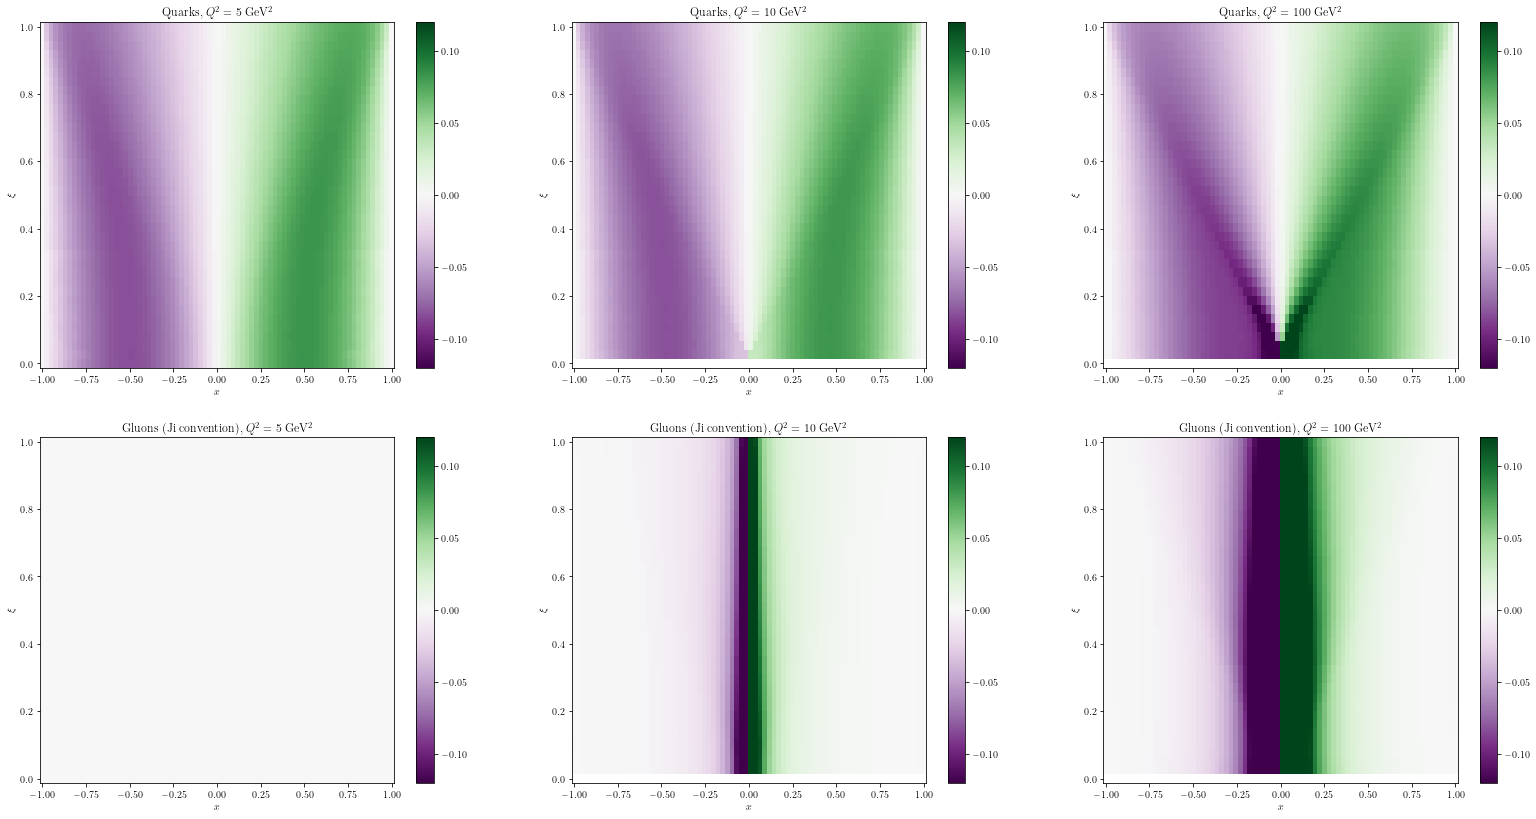

In [23]:
# AF: this is a test cell for the singlet evolution
SingletEvoObject = SingletEvolution(Telemachus)

# The intial GPDs &  scale
HQ0 = Telemachus.Hu + Telemachus.Hd - torch.flip(Telemachus.Hu,[0]) - torch.flip(Telemachus.Hd,[0])
HG0 = 2*Telemachus.x_*Telemachus.Hg
mu2ini = 5

# Evolution
HQ10, HG10 = SingletEvoObject.evolve(torch.clone(HQ0), torch.clone(HG0), mu2ini, 10, steps=5)

# Evolution
HQ100, HG100 = SingletEvoObject.evolve(torch.clone(HQ0), torch.clone(HG0), mu2ini, 100, steps=5)

# For Ji convention, divide the results of gluon evolution ...
HG10 /= 2*Telemachus.x_
HG100 /= 2*Telemachus.x_

# Test cell for evolved GPD plots

# Overall plot with subplots
nrows,ncols=2,3
fig = plt.figure(figsize=(ncols*9,nrows*7))

# Reused arrays
x  = Telemachus.x_.cpu().numpy()
xi = Telemachus.xi_.cpu().numpy()

# Quark singlet first ...

# Pre-evolution
ax1 = plt.subplot(nrows,ncols,1)
c = ax1.pcolor(x, xi, HQ0.cpu().numpy(), vmin=-0.12, vmax=0.12, cmap='PRGn')
_ = ax1.set_title(r'Quarks, $Q^2=5$~GeV$^2$')
_ = ax1.set_xlabel(r'$x$')  
_ = ax1.set_ylabel(r'$\xi$')
fig.colorbar(c, ax=ax1)

# Some evolution
ax2 = plt.subplot(nrows,ncols,2)
c = ax2.pcolor(x, xi, HQ10.cpu().numpy(), vmin=-0.12, vmax=0.12, cmap='PRGn')
_ = ax2.set_title(r'Quarks, $Q^2=10$~GeV$^2$')
_ = ax2.set_xlabel(r'$x$')  
_ = ax2.set_ylabel(r'$\xi$')
fig.colorbar(c, ax=ax2)

# Lotsa evolution
ax3 = plt.subplot(nrows,ncols,3)
c = ax3.pcolor(x, xi, HQ100.cpu().numpy(), vmin=-0.12, vmax=0.12, cmap='PRGn')
_ = ax3.set_title(r'Quarks, $Q^2=100$~GeV$^2$')
_ = ax3.set_xlabel(r'$x$')  
_ = ax3.set_ylabel(r'$\xi$')
fig.colorbar(c, ax=ax3)

# Gluons next ...

# Pre-evolution
ax4 = plt.subplot(nrows,ncols,4)
c = ax4.pcolor(x, xi, HG0.cpu().numpy(), vmin=-0.12, vmax=0.12, cmap='PRGn')
_ = ax4.set_title(r'Gluons (Ji convention), $Q^2=5$~GeV$^2$')
_ = ax4.set_xlabel(r'$x$')  
_ = ax4.set_ylabel(r'$\xi$')
fig.colorbar(c, ax=ax4)

# Some evolution
ax5 = plt.subplot(nrows,ncols,5)
c = ax5.pcolor(x, xi, HG10.cpu().numpy(), vmin=-0.12, vmax=0.12, cmap='PRGn')
_ = ax5.set_title(r'Gluons (Ji convention), $Q^2=10$~GeV$^2$')
_ = ax5.set_xlabel(r'$x$')  
_ = ax5.set_ylabel(r'$\xi$')
fig.colorbar(c, ax=ax5)

# Lotsa evolution
ax6 = plt.subplot(nrows,ncols,6)
c = ax6.pcolor(x, xi, HG100.cpu().numpy(), vmin=-0.12, vmax=0.12, cmap='PRGn')
_ = ax6.set_title(r'Gluons (Ji convention), $Q^2=100$~GeV$^2$')
_ = ax6.set_xlabel(r'$x$')  
_ = ax6.set_ylabel(r'$\xi$')
fig.colorbar(c, ax=ax6)

In [30]:
# ZY: Polarized GPD evolution code --- QQ
class Pol_SingletEvolutionQQ(BASE):

    def __init__(self,model):
        super().__init__(model)
        self.setup_kernels(model)
        self.model = model
    
    def test(self, msg, tensor):
        print(msg, torch.any(torch.isinf(tensor)), torch.any(torch.isnan(tensor)))

    def setup_kernels(self, model):
        
        #----------------------------------------------------------------
        #! y depedent kernels 
        y, x, xi = torch.meshgrid(model.y, model.x, model.xi)
        self.y__ = y
        
        # middle part
        KM1 = (2 * xi * y + x**2 + y**2) / ((xi + y) * (y**2 - x**2))
        KM1[y <= x] = 0
        KM2 = -(xi - x) * (2 * xi * x + x**2 + y**2) / ((xi**2 - y**2) * (y**2 - x**2))
        KM2[y <= 0] = 0; KM2[y >= x] = 0
        KM = KM1 + KM2
        KM[torch.logical_not(self.pos_erbl(x, xi))] = 0
        
        # right part
        KR = (-2 * xi**2 + x**2 + y**2) / ((y - x) * (y**2 - xi**2))
        KR[y <= x] = 0
        KR[torch.logical_not(self.pos_dglap(x, xi))] = 0
        self.K1 = 2 * (KM + KR) / (3 * np.pi)

        #----------------------------------------------------------------
        #! y indepedent kernels 
        x, xi = torch.meshgrid(model.x, model.xi)
        
        # middle part
        KM = torch.log((1 - x**2) / ((xi + x) * (xi + 1))) + (xi - x) / (2 * xi) * torch.log((xi + x) / (xi - x)) + 3/2
        KM[torch.logical_not(self.pos_erbl(x, xi))] = 0
        
        # right part
        KR = 3/2 + 2*torch.log(1-x) + (x-xi)/(2*xi)*torch.log((x-xi)*(1+xi)) - (x+xi)/(2*xi)*torch.log((xi+x)*(1-xi))
        KR[torch.logical_not(self.pos_dglap(x, xi))] = 0
        
        self.K2 = 2 * (KM + KR) / (3 * np.pi)
        
        
    def get_shift(self, mu2, H):
        #shift = self.get_conv(self.K0, H, self.zeros_)
        shift = self.get_conv(self.K1, H, H)
        shift += self.K2 * H
        aS = get_alphaS(mu2)    
        return aS * shift    


In [36]:
# ZY: Polarized GPD evolution code --- QG
class Pol_SingletEvolutionQG(BASE):

    def __init__(self,model):
        super().__init__(model)
        self.setup_kernels(model)
        self.model = model
    
    def setup_kernels(self, model):
        
        #----------------------------------------------------------------
        #! y depedent kernels 
        y, x, xi = torch.meshgrid(model.y, model.x, model.xi)
        self.y__ = y
        
        #! kernels without subtraction
        # only middle part
        KM = 1 / (xi + y)**2
        KM[y <= x] = 0
        KM[torch.logical_not(self.pos_erbl(x, xi))] = 0
        self.K0 = KM / (2 * np.pi)

        #! kernels with subtraction
        # middle part
        KM = -2 * (xi - x) * y / (xi**2 - y**2)**2
        KM[y >= x] = 0; KM[y <= 0] = 0
        KM[torch.logical_not(self.pos_erbl(x, xi))] = 0
        # right part
        KR = -(xi**2 + y**2 - 2 * x * y) / (xi**2 - y**2)**2
        KR[y <= x] = 0
        KR[torch.logical_not(self.pos_dglap(x, xi))] = 0
        self.K1 = (KM + KR) / (2 * np.pi)
        
        #----------------------------------------------------------------
        #! y indepedent kernels 
        x, xi = torch.meshgrid(model.x, model.xi)
        # middle part
        KM = -x**2 / (xi**2 * (xi + x))
        KM[torch.logical_not(self.pos_erbl(x, xi))] = 0
        # right part
        KR = (1 + x) / (1 - xi**2)
        KR[torch.logical_not(self.pos_dglap(x, xi))] = 0
        self.K2 = (KM + KR) / (2 * np.pi)
    
    
    def get_shift(self, mu2, H):
        # ZY: create the subtraction term H(xi, xi)
        Hsub = torch.clone(H)
        x_step = (self.model.x[1] - self.model.x[0]).item()
        index = abs(x - xi) < 0.5 * x_step
        assert Hsub[index].size(dim=0) is Hsub.size(dim = 1)
        Hsub = Hsub[index].expand(Hsub.size(dim=0), -1)

        shift = self.get_conv(self.K0, H, self.zeros_)
        shift += self.get_conv(self.K1, H, Hsub)
        shift += self.K2 * Hsub

        aS = get_alphaS(mu2) 
        Nf = get_Nf(mu2)
        
        return Nf * aS * shift    
    


In [32]:
# ZY: Polarized GPD evolution code --- GQ
class Pol_SingletEvolutionGQ(BASE):

    def __init__(self,model):
        super().__init__(model)
        self.setup_kernels(model)
        self.model = model
    
    def test(self, msg, tensor):
        print(msg, torch.any(torch.isinf(tensor)), torch.any(torch.isnan(tensor)))

    def setup_kernels(self, model):
        
        #----------------------------------------------------------------
        #! only y depedent kernels and without subtraction
        y, x, xi = torch.meshgrid(model.y, model.x, model.xi)
        self.y__ = y
        
        # middle part
        KM1 = 2 * x / (xi + y)
        KM1[y <= x] = 0
        KM2 = -(xi - x)**2 * y / (xi * (xi**2 - y**2))
        KM2[y <= 0] = 0; KM2[y >= x] = 0
        KM = KM1 + KM2
        KM[torch.logical_not(self.pos_erbl(x, xi))] = 0
        
        # right part
        KR = (xi**2 + x**2 - 2 * x * y) / (xi**2 - y**2)
        KR[y <= x] = 0
        KR[torch.logical_not(self.pos_dglap(x, xi))] = 0
        
        self.K0 = 2 * (KM + KR) / (3 * np.pi)
    
    
    def get_shift(self, mu2, H):
        shift = self.get_conv(self.K0, H, self.zeros_)
        aS = get_alphaS(mu2) 
        
        return aS * shift    

In [37]:
# ZY: Polarized GPD evolution code --- GG
class Pol_SingletEvolutionGG(BASE):

    def __init__(self,model):
        super().__init__(model)
        self.setup_kernels(model)
        self.model = model

    def setup_kernels(self, model):
        
        #! y depedent kernels 
        y, x, xi = torch.meshgrid(model.y, model.x, model.xi)
        self.y__ = y

        #! kernels with subtraction H(y, xi) - H(x, xi)
        KM1 = 2 * x * (xi**2 + 2 * xi * y + 2 * y**2 - x**2) / ((xi + y)**2 * (y**2 - x**2))
        KM1[y <= x] = 0
        KM2 = 2 * y * (y**2 - xi**2 - 2 * x**2 - 2 * xi * x) / ((xi + x)**2 * (y**2 - x**2))
        KM2[y >= x] = 0; KM2[y <= 0] = 0
        KM = KM1 + KM2
        KM[torch.logical_not(self.pos_erbl(x, xi))] = 0 
        KR = 2 / (y - x)
        KR[y <= x] = 0
        KR[torch.logical_not(self.pos_dglap(x, xi))] = 0
        self.K1 = 3 * (KM + KR) / (2 * np.pi)
        
        #! kernels with subtraction H(y, xi) - H(xi, xi)
        KM = 2 * (xi - x) * y * (y**2 - xi**2 - 2 * x**2 - 2 * xi * x) / ((xi + x) * (xi**2 - y**2)**2)
        KM += 2 * y * (y**2 - xi**2 - 2 * x**2 - 2 * xi * x) / ((xi + x)**2 * (xi**2 - y**2))
        KM[y >= x] = 0; KM[y <= 0] = 0
        KM[torch.logical_not(self.pos_erbl(x,xi))] = 0 
        KR = 2 * (x * (xi**2 + y**2) - y * (x**2 + y**2 - xi**2)) / (xi**2 - y**2)**2
        KR[y <= x] = 0
        KR[torch.logical_not(self.pos_dglap(x, xi))] = 0
        self.K2 = 3 * (KM + KR) / (2 * np.pi)

        #! y indepedent kernels 
        x, xi = torch.meshgrid(model.x, model.xi)
        
        #!-- H(xi,xi) - H(x,xi)
        KM = 2 * x**3 / (xi**2 * (xi + x)) + x**2 / (xi + x)**2 + torch.log(xi**2 / (xi**2 - x**2))
        KM *= -1
        KM[torch.logical_not(self.pos_erbl(x, xi))] = 0 
        KR = 2 * (xi**2 - x) / (xi**2 - 1) - 2 + torch.log((xi**2 - x**2) / (xi**2 - 1))
        KR *= -1
        KR[torch.logical_not(self.pos_dglap(x, xi))] = 0
        self.K3 = 3 * (KM + KR) / (2 * np.pi)
 
        #!-- H(x, xi)
        KM = 2 * x * (1 - x) / ((xi + x) * (1 + x)) 
        KM += - 2 * x**3 / (xi**2 * (xi + x)) 
        KM += torch.log(x**2 * (1 - x) / (xi**2 * (1 + x)))
        KM[torch.logical_not(self.pos_erbl(x, xi))] = 0 
        KR = 2 * (x - 1) / (1 - xi**2) + torch.log((1 - x)**2 / (1 - xi**2))
        KR[torch.logical_not(self.pos_dglap(x, xi))] = 0
        self.K4 = 3 * (KM + KR) / (2 * np.pi)

        #!-- H(xi, xi)
        KR = 2 * ((2 * x - xi**2 - x**2) / (xi**2 - 1) + 1)
        KR[torch.logical_not(self.pos_dglap(x, xi))] = 0 
        self.K5 = 3 * KR / (2 * np.pi)
        
    
    def get_shift(self, mu2, H):
        aS = get_alphaS(mu2) 
        
        # ZY: create the subtraction term H(xi, xi)
        Hsub = torch.clone(H)
        x_step = (self.model.x[1] - self.model.x[0]).item()
        index = abs(x - xi) < 0.5 * x_step
        assert Hsub[index].size(dim=0) is Hsub.size(dim = 1)
        Hsub = Hsub[index].expand(Hsub.size(dim=0), -1)

        shift  = self.get_conv(self.K1, H, H)
        shift += self.get_conv(self.K2, H, Hsub)
        
        shift += self.K3 * (Hsub - H)
        shift += self.K4 * H
        shift += self.K5 * Hsub
        
        return aS * shift    

In [38]:
class Pol_SingletEvolution(BASE):
    ''' Derived class for coupled singlet evolution between HQ and HG.
    Polarized version!
    '''

    def __init__(self,model):
        ''' Contains instances of SingletEvolutionXY for X,Y=Q,G in order to call their get_shift() methods. '''
        super().__init__(model)
        self.model = model
        self.QQpart = Pol_SingletEvolutionQQ(model)
        self.QGpart = Pol_SingletEvolutionQG(model)
        self.GQpart = Pol_SingletEvolutionGQ(model)
        self.GGpart = Pol_SingletEvolutionGG(model)

    def get_shift(self,mu2,HQ,HG):
        ''' Gets the shifts for both HQ and HG in coupled singlet evolution. '''
        # All four of the shifts
        shiftQQ = self.QQpart.get_shift(mu2,HQ)
        shiftQG = self.QGpart.get_shift(mu2,HG)
        shiftGQ = self.GQpart.get_shift(mu2,HQ)
        shiftGG = self.GGpart.get_shift(mu2,HG)
        # How they add to contribute to new HQ and HG
        shiftQ = shiftQQ + shiftQG
        shiftG = shiftGQ + shiftGG
        return shiftQ, shiftG
        
    def evolve(self,HQ,HG,mu2ini,mu2fin,steps=5,z2=1):
        ''' Evolves the sinlget HQ and HG GPDs in a coupled manner. '''

        dt = np.log(mu2fin/mu2ini)/steps
        t=0
        for k in range(steps):
            mu2= np.exp(t)*mu2ini
            HQ1,HG1 = self.get_shift(mu2,HQ,HG)
            mu2= np.exp(t+dt/2)*mu2ini
            HQ2,HG2 = self.get_shift(mu2,HQ+dt*HQ1/2,HG+dt*HG1/2)
            HQ3,HG3 = self.get_shift(mu2,HQ+dt*HQ2/2,HG+dt*HG2/2)
            mu2= np.exp(t+dt)*mu2ini
            HQ4,HG4 = self.get_shift(mu2,HQ+dt*HQ3,HG+dt*HG3/2)
            HQ+=dt/6*(HQ1+2*HQ2+2*HQ3+HQ4)
            HG+=dt/6*(HG1+2*HG2+2*HG3+HG4)
            t+=dt
            mu2=np.exp(t)*mu2ini
        
        # Should have z2=-1 for helicity-independent GPDs and z2=+1 for helicity-dependent.
        # I changed the default to z2=1 from z2=0.
        if z2!=0:
            HQ[self.model.x_<0]=0
            HQ+=z2*torch.flip(HQ, dims=[0])
            HG[self.model.x_<0]=0
            HG+=-z2*torch.flip(HG, dims=[0])
        return HQ, HG


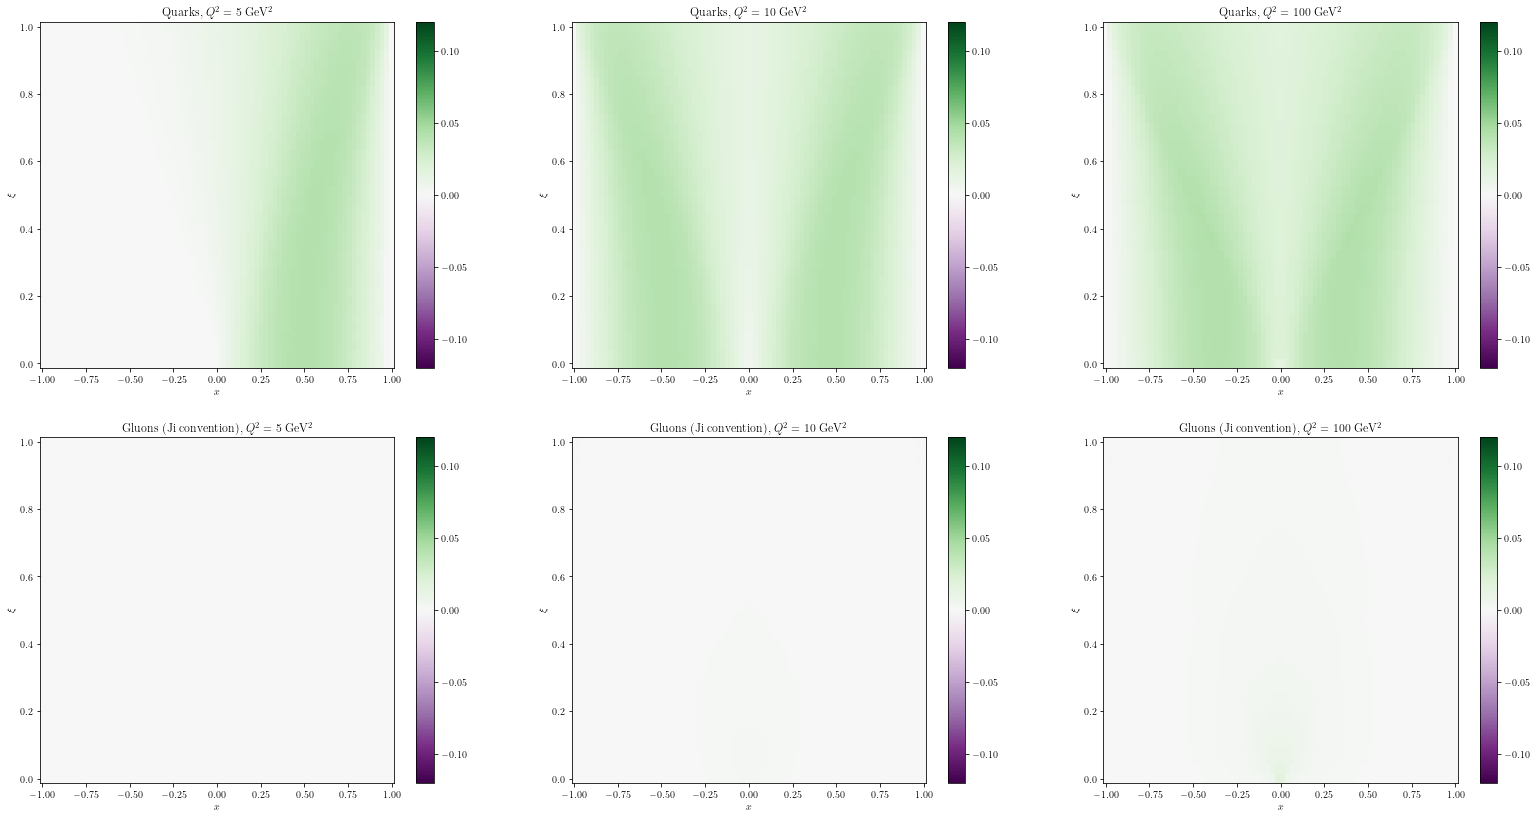

In [46]:
# AF: this is a test cell for the POLARIZED singlet evolution
# Going to be a bit silly and just evolve the PDF I have as if it's a polarized PDF...
# This is just to make sure everything runs and functions after all
SingletEvoObject = Pol_SingletEvolution(Telemachus)

# The intial GPDs &  scale
HQ0 = Telemachus.Hu
HG0 = 2*Telemachus.x_*Telemachus.Hg
mu2ini = 5

# Evolution
HQ10, HG10 = SingletEvoObject.evolve(torch.clone(HQ0), torch.clone(HG0), mu2ini, 10, steps=5)

# Evolution
HQ100, HG100 = SingletEvoObject.evolve(torch.clone(HQ0), torch.clone(HG0), mu2ini, 100, steps=5)

# For Ji convention, divide the results of gluon evolution ...
HG10 /= 2*Telemachus.x_
HG100 /= 2*Telemachus.x_

# Test cell for evolved GPD plots

# Overall plot with subplots
nrows,ncols=2,3
fig = plt.figure(figsize=(ncols*9,nrows*7))

# Reused arrays
x  = Telemachus.x_.cpu().numpy()
xi = Telemachus.xi_.cpu().numpy()

# Quark singlet first ...

# Pre-evolution
ax1 = plt.subplot(nrows,ncols,1)
c = ax1.pcolor(x, xi, HQ0.cpu().numpy(), vmin=-0.12, vmax=0.12, cmap='PRGn')
_ = ax1.set_title(r'Quarks, $Q^2=5$~GeV$^2$')
_ = ax1.set_xlabel(r'$x$')  
_ = ax1.set_ylabel(r'$\xi$')
fig.colorbar(c, ax=ax1)

# Some evolution
ax2 = plt.subplot(nrows,ncols,2)
c = ax2.pcolor(x, xi, HQ10.cpu().numpy(), vmin=-0.12, vmax=0.12, cmap='PRGn')
_ = ax2.set_title(r'Quarks, $Q^2=10$~GeV$^2$')
_ = ax2.set_xlabel(r'$x$')  
_ = ax2.set_ylabel(r'$\xi$')
fig.colorbar(c, ax=ax2)

# Lotsa evolution
ax3 = plt.subplot(nrows,ncols,3)
c = ax3.pcolor(x, xi, HQ100.cpu().numpy(), vmin=-0.12, vmax=0.12, cmap='PRGn')
_ = ax3.set_title(r'Quarks, $Q^2=100$~GeV$^2$')
_ = ax3.set_xlabel(r'$x$')  
_ = ax3.set_ylabel(r'$\xi$')
fig.colorbar(c, ax=ax3)

# Gluons next ...

# Pre-evolution
ax4 = plt.subplot(nrows,ncols,4)
c = ax4.pcolor(x, xi, HG0.cpu().numpy(), vmin=-0.12, vmax=0.12, cmap='PRGn')
_ = ax4.set_title(r'Gluons (Ji convention), $Q^2=5$~GeV$^2$')
_ = ax4.set_xlabel(r'$x$')  
_ = ax4.set_ylabel(r'$\xi$')
fig.colorbar(c, ax=ax4)

# Some evolution
ax5 = plt.subplot(nrows,ncols,5)
c = ax5.pcolor(x, xi, HG10.cpu().numpy(), vmin=-0.12, vmax=0.12, cmap='PRGn')
_ = ax5.set_title(r'Gluons (Ji convention), $Q^2=10$~GeV$^2$')
_ = ax5.set_xlabel(r'$x$')  
_ = ax5.set_ylabel(r'$\xi$')
fig.colorbar(c, ax=ax5)

# Lotsa evolution
ax6 = plt.subplot(nrows,ncols,6)
c = ax6.pcolor(x, xi, HG100.cpu().numpy(), vmin=-0.12, vmax=0.12, cmap='PRGn')
_ = ax6.set_title(r'Gluons (Ji convention), $Q^2=100$~GeV$^2$')
_ = ax6.set_xlabel(r'$x$')  
_ = ax6.set_ylabel(r'$\xi$')
fig.colorbar(c, ax=ax6)

In [102]:
class Evolver(BASE):
    ''' A class for evolving GPDs. '''
    _eps = 1e-6
    _mc2 = 1.29**2
    _mb2 = 4.18**2
    _mt2 = 172.76**2

    def __init__(self,model):
        ''' Contains instances of SingletEvolutionXY for X,Y=Q,G in order to call their get_shift() methods. '''
        super().__init__(model)
        self.model = model
        # For now, assume unpolarized. I can give it a switch to do either later.
        self.NonSingletEvolver =  NonSingletEvolution(model)
        self.SingletEvolver = SingletEvolution(model)
        # Set up physical quarks/gluons
        self.Hu = model.Hu
        self.Hd = model.Hd
        self.Hs = model.Hs
        self.Hc = model.Hc
        self.Hb = model.Hb
        self.Ht = model.Ht
        self.Hg = model.Hg
        # Inherit mu2 scale from model
        self.mu2 = model.mu2
        self.Nf  = get_Nf(self.mu2)
        return
    
    def makeEvolutionBasis(self):
        # Plus-type distributions
        Hu_pls = self.Hu - torch.flip(self.Hu,[0])
        Hd_pls = self.Hd - torch.flip(self.Hd,[0])
        Hs_pls = self.Hs - torch.flip(self.Hs,[0])
        Hc_pls = self.Hc - torch.flip(self.Hc,[0])
        Hb_pls = self.Hb - torch.flip(self.Hb,[0])
        Ht_pls = self.Ht - torch.flip(self.Ht,[0])
        # Minus-type distributions
        self.Hu_min = self.Hu + torch.flip(self.Hu,[0])
        self.Hd_min = self.Hd + torch.flip(self.Hd,[0])
        self.Hs_min = self.Hs + torch.flip(self.Hs,[0])
        self.Hc_min = self.Hc + torch.flip(self.Hc,[0])
        self.Hb_min = self.Hb + torch.flip(self.Hb,[0])
        self.Ht_min = self.Ht + torch.flip(self.Ht,[0])
        # Singlet
        self.HS = Hu_pls + Hd_pls + Hs_pls + Hc_pls + Hb_pls + Ht_pls
        # The TNS-type arrays
        self.T3  = Hu_pls - Hd_pls
        self.T8  = Hu_pls + Hd_pls - 2*Hs_pls
        self.T15 = Hu_pls + Hd_pls + Hs_pls - 3*Hc_pls
        self.T24 = Hu_pls + Hd_pls + Hs_pls + Hc_pls - 4*Hb_pls
        self.T35 = Hu_pls + Hd_pls + Hs_pls + Hc_pls + Hb_pls - 5*Ht_pls
        return
    
    def makePhysicalBasis(self):
        # Reconstruct H+ arrays from TNS-type and HS
        if(self.mu2 > self._mt2):
            Ht_pls = (self.HS - self.T35) / 6
        else:
            Ht_pls = torch.clone(self.Ht)
        if(self.mu2 > self._mb2):
            Hb_pls = (self.HS - Ht_pls - self.T24) / 5
        else:
            Hb_pls = torch.clone(self.Hb)
        if(self.mu2 > self._mc2):
            Hc_pls = (self.HS - Ht_pls - Hb_pls - self.T15) / 4
        else:
            Hc_pls = torch.clone(self.Hc)
        #Ht_pls = (self.HS - self.T35) / 6
        #Hb_pls = (self.HS - Ht_pls - self.T24) / 5
        #Hc_pls = (self.HS - Ht_pls - Hb_pls - self.T15) / 4   
        Hs_pls = (self.HS - Ht_pls - Hb_pls - Hc_pls - self.T8) / 3
        Hd_pls = (self.HS - Ht_pls - Hb_pls - Hc_pls - Hs_pls - self.T3) / 2
        Hu_pls = self.T3 + Hd_pls
        # Reconstruct quark arrays from H+ and H-
        self.Hu = (Hu_pls + self.Hu_min) / 2
        self.Hd = (Hd_pls + self.Hd_min) / 2
        self.Hs = (Hs_pls + self.Hs_min) / 2
        self.Hc = (Hc_pls + self.Hc_min) / 2
        self.Hb = (Hb_pls + self.Hb_min) / 2
        self.Ht = (Ht_pls + self.Ht_min) / 2
        return

    def _evolveFixedFlavor(self, mu2fin, steps=5):
        # Set up evolution basis
        self.makeEvolutionBasis()
        # Non-singlet evolution, TNS-type
        T3_new  = self.NonSingletEvolver.evolve(torch.clone(self.T3),  self.mu2, mu2fin, steps=steps)
        T8_new  = self.NonSingletEvolver.evolve(torch.clone(self.T8),  self.mu2, mu2fin, steps=steps)
        T15_new = self.NonSingletEvolver.evolve(torch.clone(self.T15), self.mu2, mu2fin, steps=steps)
        T24_new = self.NonSingletEvolver.evolve(torch.clone(self.T24), self.mu2, mu2fin, steps=steps)
        T35_new = self.NonSingletEvolver.evolve(torch.clone(self.T35), self.mu2, mu2fin, steps=steps)
        # Non-singlet evolution, minus-type
        Hu_min_new =self.NonSingletEvolver.evolve(torch.clone(self.Hu_min), self.mu2, mu2fin, steps=steps)
        Hd_min_new =self.NonSingletEvolver.evolve(torch.clone(self.Hd_min), self.mu2, mu2fin, steps=steps)
        Hs_min_new =self.NonSingletEvolver.evolve(torch.clone(self.Hs_min), self.mu2, mu2fin, steps=steps)
        Hc_min_new =self.NonSingletEvolver.evolve(torch.clone(self.Hc_min), self.mu2, mu2fin, steps=steps)
        Hb_min_new =self.NonSingletEvolver.evolve(torch.clone(self.Hb_min), self.mu2, mu2fin, steps=steps)
        Ht_min_new =self.NonSingletEvolver.evolve(torch.clone(self.Ht_min), self.mu2, mu2fin, steps=steps)
        # Singlet evolution
        HS_new, Hg_new = self.SingletEvolver.evolve(torch.clone(self.HS), torch.clone(self.Hg), self.mu2, mu2fin, steps=steps)
        # Now save the results of the evolution
        self.T3  = T3_new
        self.T8  = T8_new
        self.T15 = T15_new
        self.T24 = T24_new
        self.T35 = T35_new
        self.Hu_min = Hu_min_new
        self.Hd_min = Hd_min_new
        self.Hs_min = Hs_min_new
        self.Hc_min = Hc_min_new
        self.Hb_min = Hb_min_new
        self.Ht_min = Ht_min_new
        self.HS = HS_new
        self.Hg = Hg_new
        # Update the mu2 to reflect the evolution
        self.mu2 = mu2fin
        self.Nf = get_Nf(self.mu2)
        # Reconstruct physical basis
        self.makePhysicalBasis()
        return
    
    def _evolveVariableFlavor(self, mu2fin, steps=5):
        mu2 = self.mu2
        # Check for charm mass threshold
        while(mu2 < self._mc2):
            if(mu2fin > self._mc2):
                self._evolveFixedFlavor(self._mc2-self._eps, steps=steps)
                mu2 = self._mc2 + self._eps
            else:
                self._evolveFixedFlavor(mu2fin, steps=steps)
                return
        self.mu = mu2
        self.Nf = get_Nf(self.mu2)
        # Check for bottom mass threshold
        while(mu2 < self._mb2):
            if(mu2fin > self._mb2):
                self._evolveFixedFlavor(self._mb2-self._eps, steps=steps)
                mu2 = self._mb2 + self._eps
            else:
                self._evolveFixedFlavor(mu2fin, steps=steps)
                return
        self.mu = mu2
        self.Nf = get_Nf(self.mu2)
        # Check for top mass threshold
        while(mu2 < self._mt2):
            if(mu2fin > self._mt2):
                self._evolveFixedFlavor(self._mt2-self._eps, steps=steps)
                mu2 = self._mt2 + self._eps
            else:
                self._evolveFixedFlavor(mu2fin, steps=steps)
                return
        self.mu2 = mu2
        self.Nf = get_Nf(self.mu2)
        # Finish the evolution
        self._evolveFixedFlavor(mu2fin, steps=steps)
        return
    
    def evolve(self, mu2fin, steps=5):
        # Raise an error if user asks to evolve backwards?
        assert(mu2fin > self.mu2)
        # Call the variable flavor thingy
        self._evolveVariableFlavor(mu2fin, steps=steps)
        return

6 4
10 4
100 5


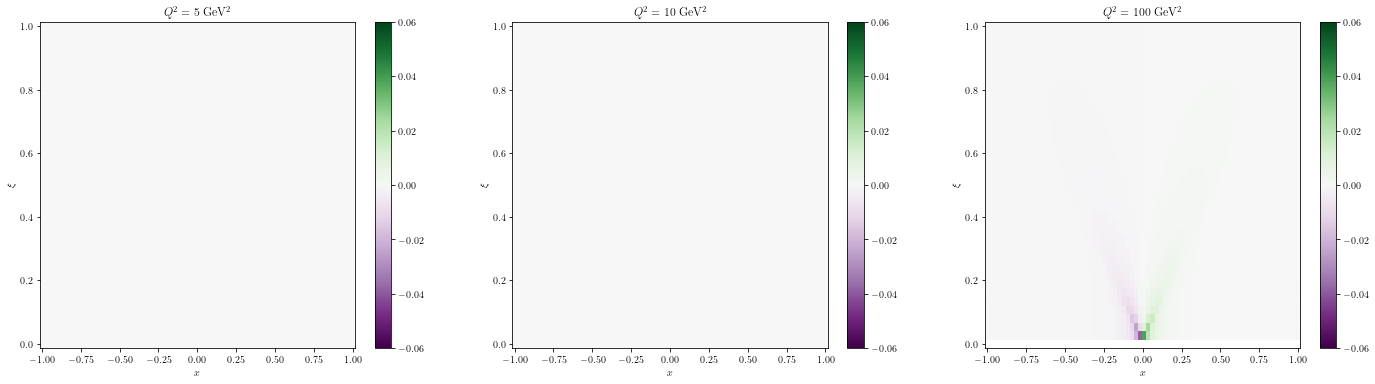

In [105]:
# Test cell
Mentor = Evolver(Telemachus)
Mentor.evolve(6)
print(Mentor.mu2,Mentor.Nf)

# Overall plot with subplots
nrows,ncols=1,3
fig = plt.figure(figsize=(ncols*8,nrows*6))

# Reused arrays
x  = Telemachus.x_.cpu().numpy()
xi = Telemachus.xi_.cpu().numpy()

# Pre-evolution
ax1 = plt.subplot(nrows,ncols,1)
c = ax1.pcolor(x, xi, Mentor.Hb.cpu().numpy(), vmin=-0.06, vmax=0.06, cmap='PRGn')
_ = ax1.set_title(r'$Q^2=5$~GeV$^2$')
_ = ax1.set_xlabel(r'$x$')  
_ = ax1.set_ylabel(r'$\xi$')
fig.colorbar(c, ax=ax1)

Mentor.evolve(10)
print(Mentor.mu2,Mentor.Nf)

# Some evolution
ax2 = plt.subplot(nrows,ncols,2)
c = ax2.pcolor(x, xi, Mentor.Hb.cpu().numpy(), vmin=-0.06, vmax=0.06, cmap='PRGn')
_ = ax2.set_title(r'$Q^2=10$~GeV$^2$')
_ = ax2.set_xlabel(r'$x$')  
_ = ax2.set_ylabel(r'$\xi$')
fig.colorbar(c, ax=ax2)

Mentor.evolve(100)
print(Mentor.mu2,Mentor.Nf)

# Lotsa evolution
ax3 = plt.subplot(nrows,ncols,3)
c = ax3.pcolor(x, xi, Mentor.Hb.cpu().numpy(), vmin=-0.06, vmax=0.06, cmap='PRGn')
_ = ax3.set_title(r'$Q^2=100$~GeV$^2$')
_ = ax3.set_xlabel(r'$x$')  
_ = ax3.set_ylabel(r'$\xi$')
fig.colorbar(c, ax=ax3)